In [0]:
from zipfile import ZipFile
file_name="dataset.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
import numpy as np
import os
import cv2
import sys
import imageio
import glob
import matplotlib.pyplot as plt
from PIL import Image
import random

path = "/content/dataset/"
file_list = os.listdir(path)
train_img=[]
for filename in file_list:
  fullpath = os.path.join(path,filename)
  first=Image.open(fullpath).convert('L')
  first =np.array(first)
  m,n=first.shape[0],first.shape[1]
  first=np.reshape(first,(m*n,))
  train_img.append(first)

train_img = np.asarray(train_img)
train_img = train_img.transpose()
images = [(cv2.imread(file, cv2.IMREAD_GRAYSCALE).flatten(), int(file[len(path):len(path)+3])) for file in glob.glob(path + "*.jpg")]
random.shuffle(images)
labels = np.array([images[i][1] for i in range(len(images))])
images = np.array([images[i][0] for i in range(len(images))])
images.shape, labels.shape

((520, 65536), (520,))

# splitting dataset



In [0]:
from sklearn.model_selection import train_test_split
images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.1)
images.shape, test_images.shape, train_labels.shape, test_labels.shape

((468, 65536), (52, 65536), (468,), (52,))

In [0]:
np.unique(train_labels), np.unique(test_labels)

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([0, 1, 2, 3, 4, 5, 6, 7]))

In [0]:
mean_face = images.mean(axis = 0)
normalized_images = (images - mean_face.reshape(1, -1))
normalized_images = normalized_images / np.std(normalized_images, axis = 0)
covariance_matrix = np.matmul(normalized_images, normalized_images.T)/normalized_images.shape[0]

(468, 468)

In [0]:
eigen_value, eigen_vector = np.linalg.eig(covariance_matrix)
eigen_value.shape, eigen_vector.shape

((468,), (468, 468))

In [0]:
order = eigen_value.argsort()[::-1]
eigen_value = eigen_value[order]
eigen_vector = eigen_vector[:,order]

In [0]:
#SELECTING GOOD VALUE OF PRINCIPLE COMPONENT
a,s,v=np.linalg.svd(covariance_matrix)
summation=np.sum(s)
for k in range(1,len(s)):
    sigma=0
    for i in range(0,k):
        sigma+=s[i]
    sigma=sigma/summation
    if(sigma>=0.9991):
        print("selected value of k is",k)
        break

selected value of k is 443


In [0]:
#number of features chosen will be, k = 334
reduced_eigen_vectors = eigen_vector[:, :360]
reduced_eigen_vectors.shape

(468, 360)

In [0]:
projected_data = np.matmul(normalized_images.transpose(), reduced_eigen_vectors)
projected_data = projected_data / np.linalg.norm(projected_data, axis = 0)

(65536, 360)

In [0]:
reduced_images = np.matmul(normalized_images, projected_data)
reduced_images.shape

(468, 360)

# Sigmoid
here,z = w1x1 + w2x2 + w0

In [0]:
def sigmoid(z):
    return 1 / (1 + np.exp(-1 * z))

In [0]:
def derivative_cross_entropy_loss(a, y, x):
    return np.matmul(x.transpose(), (a - y)) / y.shape[0]

In [0]:
small_term = 0.00000001
def cross_entropy_loss(y, a):
    return (-1*y*np.log(a + small_term) - (1 - y)*np.log(1+-1*a + small_term)).mean()

# Adding bias component in features

In [0]:
reduced_images = np.append(reduced_images, np.ones((len(reduced_images), 1)), axis = 1)
reduced_images.shape

(468, 361)

In [0]:
unique_labels = np.unique(train_labels)
unique_labels.shape

(8,)

In [0]:
weights_labels = np.random.normal(size=(len(unique_labels), reduced_images.shape[1])).astype(np.float128)
weights_labels.shape
learning_rate = 0.01
number_of_epochs = 4500
loss_per_label_per_epoch = np.zeros((len(unique_labels), number_of_epochs))


In [0]:
for label_index in range(len(unique_labels)):
    # weights = weights_labels[label_index, :]
    train_labels_new = np.zeros((train_labels.shape)); train_labels_new[train_labels == unique_labels[label_index]] = 1
    for epoch in range(number_of_epochs):
        z = np.matmul(reduced_images, weights_labels[label_index, :])
        a = sigmoid(z)
        loss_per_label_per_epoch[label_index][epoch] = cross_entropy_loss(train_labels_new, a)
        derivative = derivative_cross_entropy_loss(a.reshape(-1, 1), train_labels_new.reshape(-1, 1), reduced_images)
        weights_labels[label_index, :] = weights_labels[label_index, :] - learning_rate * derivative.flatten()

# Display losses

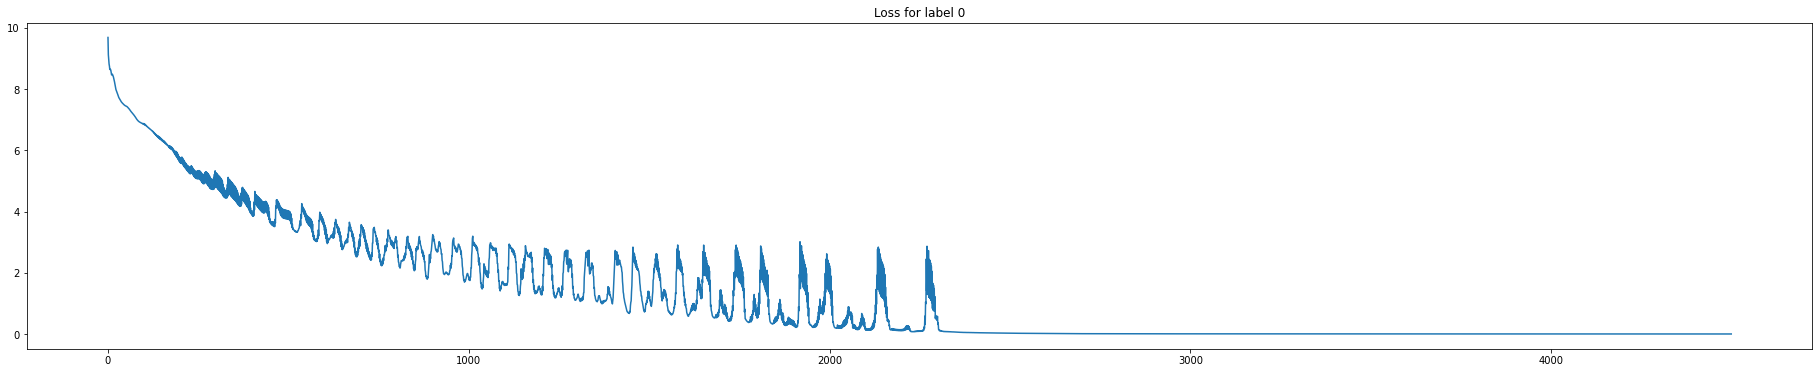

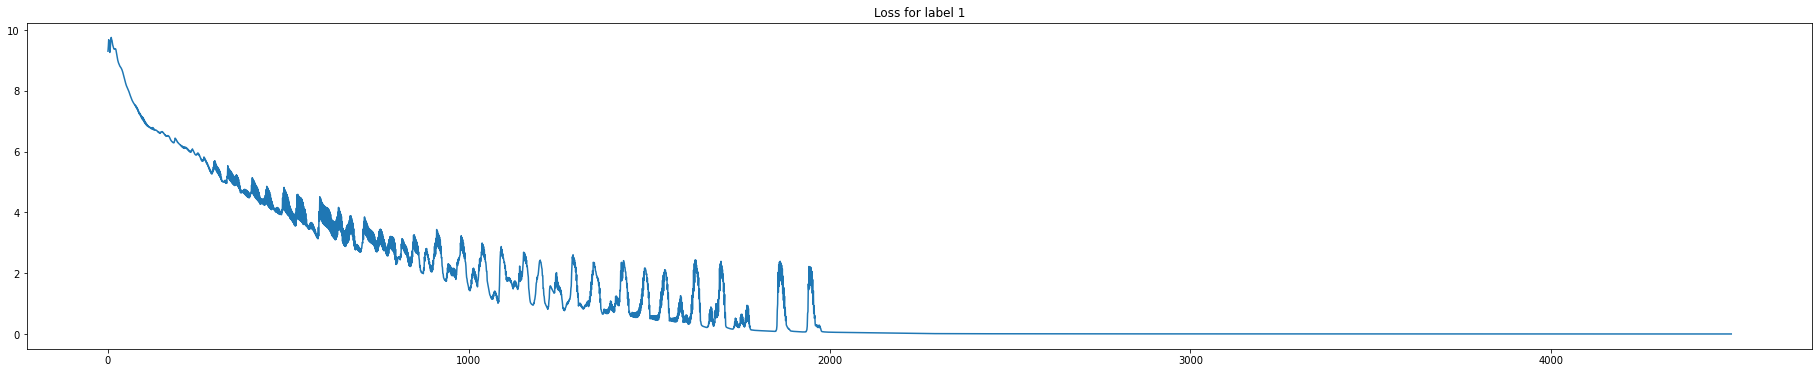

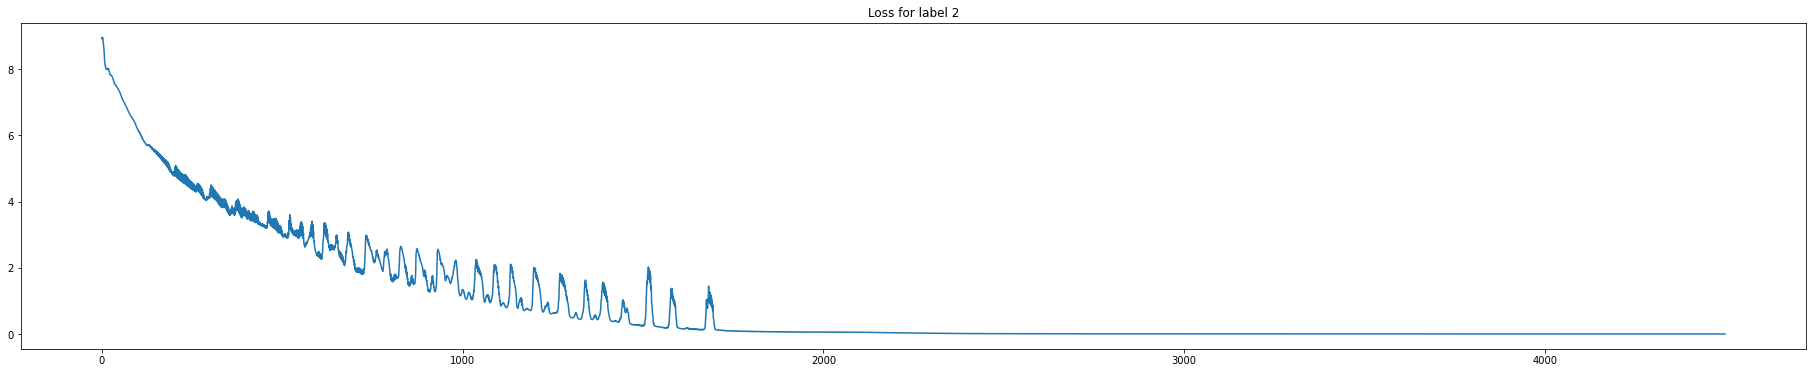

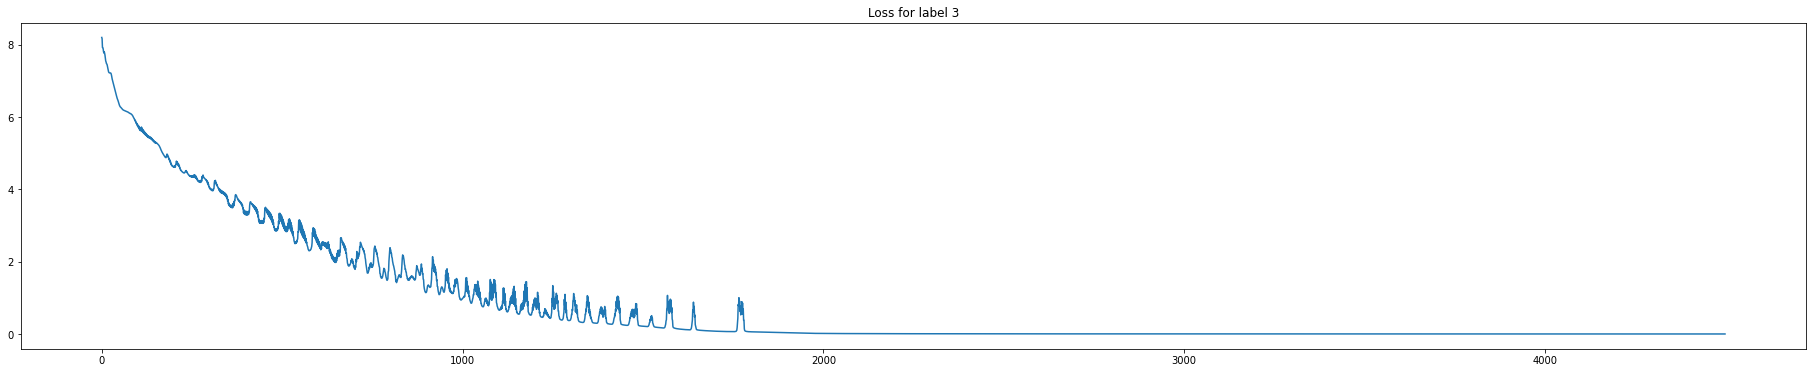

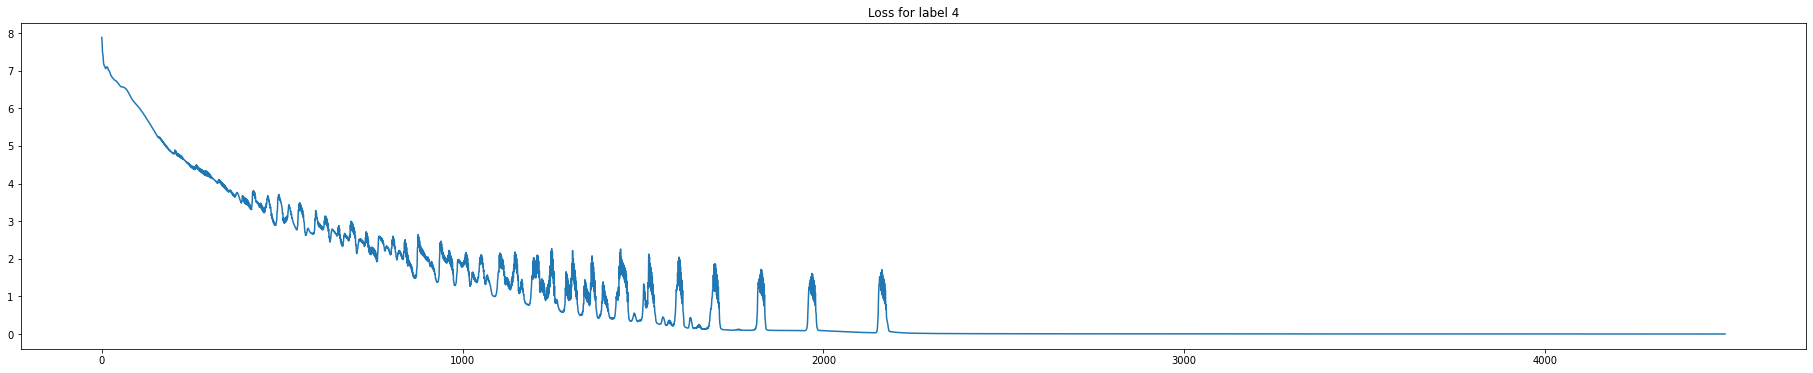

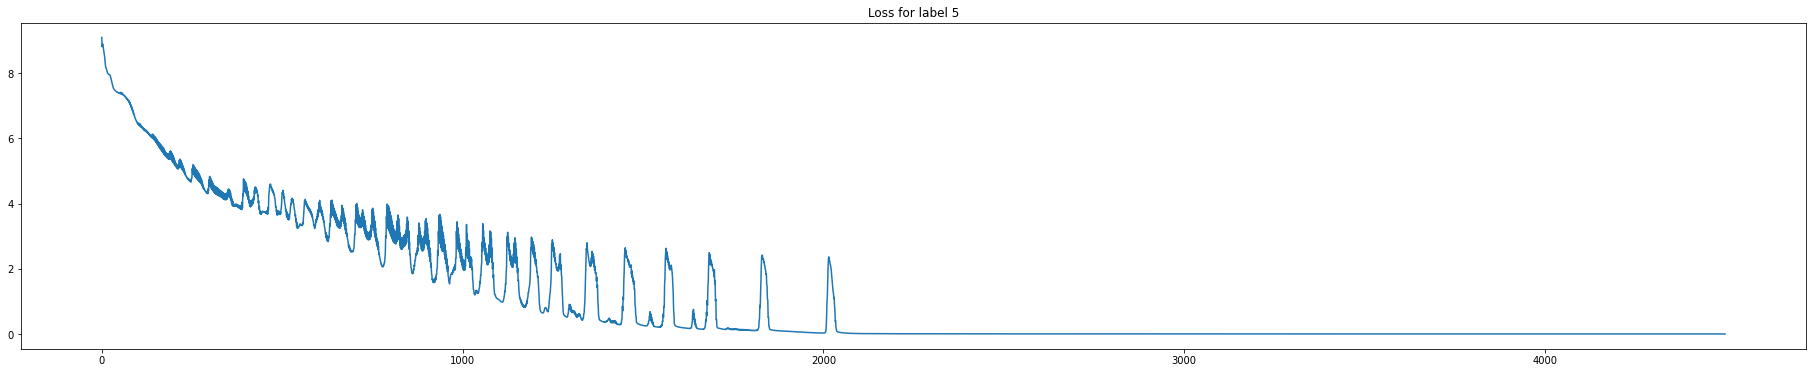

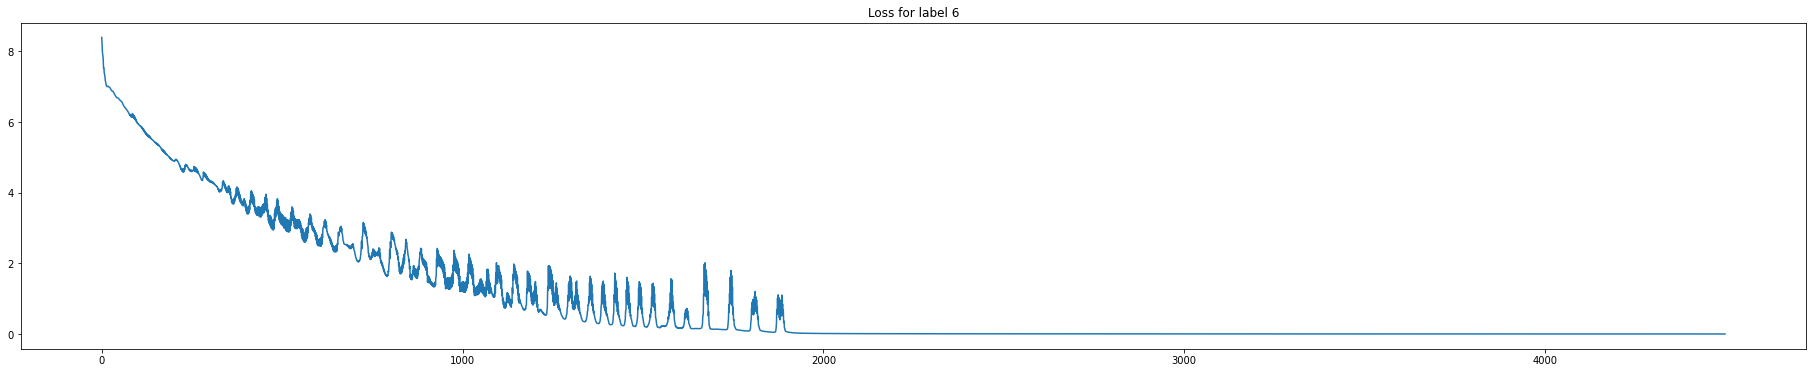

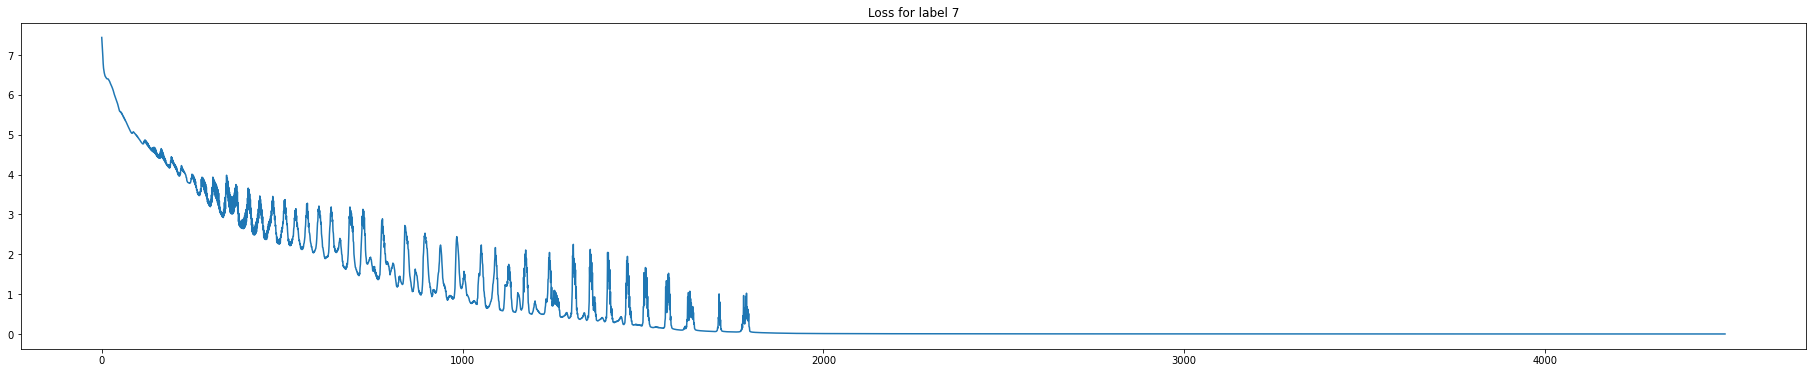

In [0]:
import matplotlib.pyplot as plt
for i in range(len(loss_per_label_per_epoch)):
    plt.figure(figsize=(32, 6))
    plt.title("Loss for label " + str(unique_labels[i]))
    plt.plot(range(number_of_epochs), loss_per_label_per_epoch[i, :])
    plt.show()

In [0]:
normalized_test_images = (test_images - mean_face.reshape(1, -1))
normalized_test_images = normalized_test_images / np.std(normalized_test_images, axis = 0)
normalized_test_images.shape

In [0]:
reduced_test_images = np.matmul(normalized_test_images, projected_data)
reduced_test_images.shape

In [0]:
reduced_test_images = np.append(reduced_test_images, np.ones((len(reduced_test_images), 1)), axis = 1)
reduced_test_images.shape

(52, 361)

In [0]:
predicted_outputs = np.zeros(len(test_images))
for i in range(len(reduced_test_images)):
    predicted_outputs[i] = unique_labels[np.matmul(reduced_test_images[i, :].reshape(1, -1), weights_labels.transpose()).flatten().argmax()]

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(predicted_outputs, test_labels)

0.6923076923076923

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix( test_labels, predicted_outputs)

array([[2, 0, 2, 1, 0, 0, 0, 1],
       [0, 4, 2, 1, 3, 0, 0, 0],
       [0, 0, 3, 1, 0, 0, 0, 0],
       [0, 0, 0, 6, 1, 0, 0, 0],
       [0, 0, 0, 0, 3, 0, 0, 0],
       [0, 0, 0, 0, 1, 8, 1, 0],
       [0, 0, 0, 0, 0, 0, 3, 1],
       [0, 1, 0, 0, 0, 0, 0, 7]])